# LSTM - FastText

- ASAD Dataset
- ROS balanced
- LSTM 1, 2 and 3 Layers
- Cell: 64
- Learning-rate: 0.001
- Embedding: FastText dim 300

## Import libraries

In [15]:
import pandas as pd 
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import csv
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from keras import layers
from tensorflow.keras.layers import GlobalMaxPooling1D
from keras.layers import Bidirectional
from keras.callbacks import *
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import spatial
from gensim.utils import simple_preprocess
from keras.preprocessing import sequence
from keras.utils.vis_utils import plot_model
from keras.models import load_model
import tensorflow as tf
from imblearn.over_sampling import SMOTE, RandomOverSampler

## Load dataset

In [16]:
file='../complete_training_all_punctuation_cleaning_stopword.csv'
data = pd.read_csv(file,header=0, delimiter="\t",encoding='utf-8')
data.text=data.text.astype(str)
data.head(100)

,id,text,sentiment
0,1221875106206638080,والله الأرقام سيكون مخيب للآمال الأهلي قدها بر...,Positive
1,1221884257490042887,الزعل بيغير ملامحك بيغير نظرة العين بيغير شكلك...,Neutral
2,1226422627436310528,الحب الحقيقي اقتسام شخص أخر أقرب احلام مستغانمي,Positive
3,1221880820815798277,النهضة فتيل,Positive
4,1221884400377499651,حباً ايران بقدر ماهو نكايه بترامب وحزبه,Neutral
...,...,...,...
95,1221882259139067911,ليه اسوم حياتي غيرت وانا اعرف,Neutral
96,1221881289881550848,هههه ضحكت حالة نفسية سعيده,Positive
97,1227326811652026368,الحمدلله حضنت امي الحقيقية تعرفون شنو شعور تتر...,Positive
98,1221882556548816896,توني ادري ان قناة اسمها يمدح السوق الا اللي رب...,Neutral


In [17]:
data.shape

(53289, 3)

In [18]:
labels = data[['id', 'sentiment']]
labels.sentiment.value_counts()

Neutral     36082
Negative     8674
Positive     8533
Name: sentiment, dtype: int64

In [19]:
classes = sorted(labels.sentiment.unique())
classes

['Negative', 'Neutral', 'Positive']

In [20]:
dfs = []
for sentiment in classes:
    df_temp = data.where(data.sentiment == sentiment)
    df_temp.dropna(axis=0, inplace=True)
    dfs.append(df_temp)
ls = [len(df) for df in dfs]
ls

[8674, 36082, 8533]

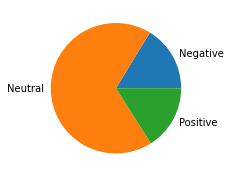

In [21]:
plt.figure(figsize=(3, 3))
plt.pie(ls, labels=classes);

## Augmented data

In [22]:
# new_dfs = [pd.concat([df]*int(max(ls)/len(df)), ignore_index=True) 
#            for df in dfs]

In [23]:
# new_ls = [len(df) for df in new_dfs]
# new_ls

In [24]:
# plt.figure(figsize=(3, 3))
# plt.pie(new_ls, labels=classes);

In [25]:
# data = pd.concat(new_dfs, ignore_index=True)
# labels = data[['id','text', 'sentiment']]
# classes = sorted(labels.sentiment.unique())
# classes

In [26]:
data["sentiment"].value_counts()
cleanup_nums = {"sentiment":     {"Neutral": 0,"Negative":2, "Positive": 1,}}
data = data.replace(cleanup_nums)
data.head(100)

,id,text,sentiment
0,1221875106206638080,والله الأرقام سيكون مخيب للآمال الأهلي قدها بر...,1
1,1221884257490042887,الزعل بيغير ملامحك بيغير نظرة العين بيغير شكلك...,0
2,1226422627436310528,الحب الحقيقي اقتسام شخص أخر أقرب احلام مستغانمي,1
3,1221880820815798277,النهضة فتيل,1
4,1221884400377499651,حباً ايران بقدر ماهو نكايه بترامب وحزبه,0
...,...,...,...
95,1221882259139067911,ليه اسوم حياتي غيرت وانا اعرف,0
96,1221881289881550848,هههه ضحكت حالة نفسية سعيده,1
97,1227326811652026368,الحمدلله حضنت امي الحقيقية تعرفون شنو شعور تتر...,1
98,1221882556548816896,توني ادري ان قناة اسمها يمدح السوق الا اللي رب...,0


## Convert to Numeric

In [27]:
maxSeqLength=30

#conversion to list and then displaying the list
text = data['text'].tolist()

#tokenizer to read all the words present in our dtaset
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

#declaring the vocab_size
size_of_vocabulary  = len(tokenizer.word_index) + 1

#conversion to numerical formats
encoded_text = tokenizer.texts_to_sequences(text)
max_length = maxSeqLength
X = sequence.pad_sequences(encoded_text, maxlen=max_length, padding='post')
y = data['sentiment']

In [28]:
# ROS
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.2, stratify = y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(86596, 30) (86596,)
(21650, 30) (21650,)


## FastText Embedding

In [29]:
%%time
from gensim.models import KeyedVectors
ar_model = KeyedVectors.load_word2vec_format("../cc.ar.300.vec")

CPU times: user 6min 13s, sys: 3.47 s, total: 6min 17s
Wall time: 6min 17s


In [30]:
words_not_found = []
embedding_dim = 300  
embedding_matrix = np.zeros((size_of_vocabulary, embedding_dim))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = ar_model.get_vector(word)
    except KeyError:
        embedding_vector = None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

## LSTM 1 Layer

In [31]:
UNITS = 64
lr = 0.001

In [32]:
model1=Sequential()
model1.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model1.add(LSTM(UNITS,return_sequences=True,dropout=0.5))

#Global Maxpooling
model1.add(GlobalMaxPooling1D())

#Dense Layer
model1.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model1.add(Dense(3,activation='softmax')) 

model1.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 300)           31476300  
_________________________________________________________________
lstm (LSTM)                  (None, 30, 64)            93440     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 31,574,095
Trainable params: 97,795
Non-trainable params: 31,476,300
_________________________________________________________________
None


In [23]:
%%time
mc1 = ModelCheckpoint('best_model_f1.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history1 = model1.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc1])

Epoch 1/200
1083/1083 [==============================] - 12s 10ms/step - loss: 0.8467 - acc: 0.6086 - val_loss: 0.7460 - val_acc: 0.6734

Epoch 00001: val_acc improved from -inf to 0.67344, saving model to best_model_f1.h5
Epoch 2/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7722 - acc: 0.6498 - val_loss: 0.7064 - val_acc: 0.6911

Epoch 00002: val_acc improved from 0.67344 to 0.69111, saving model to best_model_f1.h5
Epoch 3/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7428 - acc: 0.6673 - val_loss: 0.6797 - val_acc: 0.7092

Epoch 00003: val_acc improved from 0.69111 to 0.70918, saving model to best_model_f1.h5
Epoch 4/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.7147 - acc: 0.6836 - val_loss: 0.6529 - val_acc: 0.7245

Epoch 00004: val_acc improved from 0.70918 to 0.72448, saving model to best_model_f1.h5
Epoch 5/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.6939 - acc: 0.6951

1083/1083 [==============================] - 11s 10ms/step - loss: 0.4805 - acc: 0.7991 - val_loss: 0.4299 - val_acc: 0.8298

Epoch 00039: val_acc did not improve from 0.83170
Epoch 40/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4704 - acc: 0.8074 - val_loss: 0.4313 - val_acc: 0.8320

Epoch 00040: val_acc improved from 0.83170 to 0.83204, saving model to best_model_f1.h5
Epoch 41/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4743 - acc: 0.8053 - val_loss: 0.4273 - val_acc: 0.8318

Epoch 00041: val_acc did not improve from 0.83204
Epoch 42/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4689 - acc: 0.8079 - val_loss: 0.4240 - val_acc: 0.8334

Epoch 00042: val_acc improved from 0.83204 to 0.83343, saving model to best_model_f1.h5
Epoch 43/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4717 - acc: 0.8044 - val_loss: 0.4210 - val_acc: 0.8341

Epoch 00043: val_acc improved from 0.83343

1083/1083 [==============================] - 11s 10ms/step - loss: 0.4164 - acc: 0.8298 - val_loss: 0.3762 - val_acc: 0.8550

Epoch 00080: val_acc did not improve from 0.85647
Epoch 81/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4160 - acc: 0.8288 - val_loss: 0.3735 - val_acc: 0.8546

Epoch 00081: val_acc did not improve from 0.85647
Epoch 82/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4144 - acc: 0.8314 - val_loss: 0.3676 - val_acc: 0.8590

Epoch 00082: val_acc improved from 0.85647 to 0.85901, saving model to best_model_f1.h5
Epoch 83/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4172 - acc: 0.8290 - val_loss: 0.3840 - val_acc: 0.8514

Epoch 00083: val_acc did not improve from 0.85901
Epoch 84/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.4109 - acc: 0.8319 - val_loss: 0.3752 - val_acc: 0.8562

Epoch 00084: val_acc did not improve from 0.85901
Epoch 85/200
1083/1083 [======

1083/1083 [==============================] - 11s 10ms/step - loss: 0.3713 - acc: 0.8499 - val_loss: 0.3503 - val_acc: 0.8670

Epoch 00164: val_acc did not improve from 0.87390
Epoch 165/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.3722 - acc: 0.8494 - val_loss: 0.3360 - val_acc: 0.8718

Epoch 00165: val_acc did not improve from 0.87390
Epoch 166/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.3697 - acc: 0.8515 - val_loss: 0.3416 - val_acc: 0.8697

Epoch 00166: val_acc did not improve from 0.87390
Epoch 167/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.3721 - acc: 0.8491 - val_loss: 0.3423 - val_acc: 0.8736

Epoch 00167: val_acc did not improve from 0.87390
Epoch 168/200
1083/1083 [==============================] - 11s 10ms/step - loss: 0.3716 - acc: 0.8520 - val_loss: 0.3607 - val_acc: 0.8628

Epoch 00168: val_acc did not improve from 0.87390
Epoch 169/200
1083/1083 [==============================] - 11s 1

In [24]:
with open('history_f1.json', 'w') as f:
    json.dump(history1.history, f)

In [25]:
model1.save('themodel_f1.h5')

## LSTM 2 Layer

In [33]:
model2=Sequential()
model2.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model2.add(LSTM(UNITS,return_sequences=True,dropout=0.5))
model2.add(LSTM(UNITS,return_sequences=True))

#Global Maxpooling
model2.add(GlobalMaxPooling1D())

#Dense Layer
model2.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model2.add(Dense(3,activation='softmax')) 

model2.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 300)           31476300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 64)            93440     
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 195       
Total params: 31,607,119
Trainable params: 130,819
Non-trainable params: 31,476,300
____________________________________

In [34]:
%%time
mc2 = ModelCheckpoint('best_model_f2.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history2 = model2.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc2])

Epoch 1/200
1083/1083 [==============================] - 28s 24ms/step - loss: 0.8422 - acc: 0.6117 - val_loss: 0.7556 - val_acc: 0.6727

Epoch 00001: val_acc improved from -inf to 0.67275, saving model to best_model_f2.h5
Epoch 2/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.7846 - acc: 0.6435 - val_loss: 0.7214 - val_acc: 0.6830

Epoch 00002: val_acc improved from 0.67275 to 0.68297, saving model to best_model_f2.h5
Epoch 3/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.7570 - acc: 0.6592 - val_loss: 0.7003 - val_acc: 0.6945

Epoch 00003: val_acc improved from 0.68297 to 0.69446, saving model to best_model_f2.h5
Epoch 4/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.7326 - acc: 0.6719 - val_loss: 0.6856 - val_acc: 0.7060

Epoch 00004: val_acc improved from 0.69446 to 0.70600, saving model to best_model_f2.h5
Epoch 5/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.7148 - acc: 0.6820

1083/1083 [==============================] - 25s 23ms/step - loss: 0.4404 - acc: 0.8186 - val_loss: 0.4219 - val_acc: 0.8372

Epoch 00038: val_acc did not improve from 0.83839
Epoch 39/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.4377 - acc: 0.8215 - val_loss: 0.4113 - val_acc: 0.8423

Epoch 00039: val_acc improved from 0.83839 to 0.84226, saving model to best_model_f2.h5
Epoch 40/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.4330 - acc: 0.8213 - val_loss: 0.4092 - val_acc: 0.8434

Epoch 00040: val_acc improved from 0.84226 to 0.84342, saving model to best_model_f2.h5
Epoch 41/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.4277 - acc: 0.8246 - val_loss: 0.3999 - val_acc: 0.8473

Epoch 00041: val_acc improved from 0.84342 to 0.84729, saving model to best_model_f2.h5
Epoch 42/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.4251 - acc: 0.8256 - val_loss: 0.4002 - val_acc: 0.8462

Epoc

1083/1083 [==============================] - 26s 24ms/step - loss: 0.3500 - acc: 0.8599 - val_loss: 0.3559 - val_acc: 0.8706

Epoch 00079: val_acc improved from 0.86686 to 0.87055, saving model to best_model_f2.h5
Epoch 80/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3471 - acc: 0.8603 - val_loss: 0.3588 - val_acc: 0.8673

Epoch 00080: val_acc did not improve from 0.87055
Epoch 81/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3486 - acc: 0.8592 - val_loss: 0.3592 - val_acc: 0.8695

Epoch 00081: val_acc did not improve from 0.87055
Epoch 82/200
1083/1083 [==============================] - 25s 24ms/step - loss: 0.3477 - acc: 0.8611 - val_loss: 0.3851 - val_acc: 0.8574

Epoch 00082: val_acc did not improve from 0.87055
Epoch 83/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3473 - acc: 0.8608 - val_loss: 0.3555 - val_acc: 0.8677

Epoch 00083: val_acc did not improve from 0.87055
Epoch 84/200
1083/1083 [======

1083/1083 [==============================] - 25s 24ms/step - loss: 0.3065 - acc: 0.8787 - val_loss: 0.3550 - val_acc: 0.8756

Epoch 00120: val_acc did not improve from 0.88187
Epoch 121/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3081 - acc: 0.8782 - val_loss: 0.3469 - val_acc: 0.8800

Epoch 00121: val_acc did not improve from 0.88187
Epoch 122/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3066 - acc: 0.8779 - val_loss: 0.3534 - val_acc: 0.8751

Epoch 00122: val_acc did not improve from 0.88187
Epoch 123/200
1083/1083 [==============================] - 26s 24ms/step - loss: 0.3066 - acc: 0.8774 - val_loss: 0.3541 - val_acc: 0.8767

Epoch 00123: val_acc did not improve from 0.88187
Epoch 124/200
1083/1083 [==============================] - 25s 23ms/step - loss: 0.3066 - acc: 0.8792 - val_loss: 0.3436 - val_acc: 0.8790

Epoch 00124: val_acc did not improve from 0.88187
Epoch 125/200
1083/1083 [==============================] - 25s 2


Epoch 00162: val_acc did not improve from 0.88828
Epoch 163/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.2827 - acc: 0.8888 - val_loss: 0.3573 - val_acc: 0.8804

Epoch 00163: val_acc did not improve from 0.88828
Epoch 164/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.2806 - acc: 0.8882 - val_loss: 0.3344 - val_acc: 0.8862

Epoch 00164: val_acc did not improve from 0.88828
Epoch 165/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.2832 - acc: 0.8890 - val_loss: 0.3510 - val_acc: 0.8804

Epoch 00165: val_acc did not improve from 0.88828
Epoch 166/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.2791 - acc: 0.8903 - val_loss: 0.3605 - val_acc: 0.8805

Epoch 00166: val_acc did not improve from 0.88828
Epoch 167/200
1083/1083 [==============================] - 19s 17ms/step - loss: 0.2794 - acc: 0.8898 - val_loss: 0.3436 - val_acc: 0.8844

Epoch 00167: val_acc did not improve from 0.88828

In [37]:
with open('history_f2.json', 'w') as f:
    json.dump(history2.history, f)

In [38]:
model2.save('themodel_f2.h5')

## LSTM 3 Layers

In [39]:
model3=Sequential()
model3.add(Embedding(size_of_vocabulary,embedding_dim,weights=[embedding_matrix],input_length=max_length,trainable=False))

#Lstm layer
model3.add(LSTM(UNITS,return_sequences=True,dropout=0.5))
model3.add(LSTM(UNITS,return_sequences=True))
model3.add(LSTM(UNITS,return_sequences=True))

#Global Maxpooling
model3.add(GlobalMaxPooling1D())

#Dense Layer
model3.add(Dense(UNITS, activation='relu'))

#Output layer 3 class
model3.add(Dense(3,activation='softmax')) 

model3.compile(optimizer=Adam(learning_rate = lr), loss = 'sparse_categorical_crossentropy', metrics = ['acc']) 
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 300)           31476300  
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            93440     
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

In [40]:
%%time
mc3 = ModelCheckpoint('best_model_f3.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)  
history3 = model3.fit(X_train, y_train, batch_size=64, epochs=200, validation_split=0.2, verbose=1, callbacks=[mc3])

Epoch 1/200
1083/1083 [==============================] - 38s 33ms/step - loss: 0.8447 - acc: 0.6131 - val_loss: 0.7475 - val_acc: 0.6634

Epoch 00001: val_acc improved from -inf to 0.66339, saving model to best_model_f3.h5
Epoch 2/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.7884 - acc: 0.6423 - val_loss: 0.7227 - val_acc: 0.6802

Epoch 00002: val_acc improved from 0.66339 to 0.68020, saving model to best_model_f3.h5
Epoch 3/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.7614 - acc: 0.6579 - val_loss: 0.7127 - val_acc: 0.6903

Epoch 00003: val_acc improved from 0.68020 to 0.69030, saving model to best_model_f3.h5
Epoch 4/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.7357 - acc: 0.6711 - val_loss: 0.6818 - val_acc: 0.7031

Epoch 00004: val_acc improved from 0.69030 to 0.70306, saving model to best_model_f3.h5
Epoch 5/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.7196 - acc: 0.6788


Epoch 00038: val_acc improved from 0.83453 to 0.83632, saving model to best_model_f3.h5
Epoch 39/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.4362 - acc: 0.8221 - val_loss: 0.4173 - val_acc: 0.8330

Epoch 00039: val_acc did not improve from 0.83632
Epoch 40/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.4286 - acc: 0.8246 - val_loss: 0.4095 - val_acc: 0.8402

Epoch 00040: val_acc improved from 0.83632 to 0.84024, saving model to best_model_f3.h5
Epoch 41/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.4235 - acc: 0.8270 - val_loss: 0.4121 - val_acc: 0.8404

Epoch 00041: val_acc improved from 0.84024 to 0.84036, saving model to best_model_f3.h5
Epoch 42/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.4226 - acc: 0.8250 - val_loss: 0.4125 - val_acc: 0.8408

Epoch 00042: val_acc improved from 0.84036 to 0.84076, saving model to best_model_f3.h5
Epoch 43/200
1083/1083 [=================

1083/1083 [==============================] - 35s 32ms/step - loss: 0.3267 - acc: 0.8684 - val_loss: 0.3652 - val_acc: 0.8692

Epoch 00079: val_acc did not improve from 0.87240
Epoch 80/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.3279 - acc: 0.8697 - val_loss: 0.3552 - val_acc: 0.8717

Epoch 00080: val_acc did not improve from 0.87240
Epoch 81/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.3266 - acc: 0.8705 - val_loss: 0.3631 - val_acc: 0.8688

Epoch 00081: val_acc did not improve from 0.87240
Epoch 82/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.3251 - acc: 0.8713 - val_loss: 0.3604 - val_acc: 0.8706

Epoch 00082: val_acc did not improve from 0.87240
Epoch 83/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.3266 - acc: 0.8693 - val_loss: 0.3461 - val_acc: 0.8745

Epoch 00083: val_acc improved from 0.87240 to 0.87454, saving model to best_model_f3.h5
Epoch 84/200
1083/1083 [======


Epoch 00120: val_acc did not improve from 0.88857
Epoch 121/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2711 - acc: 0.8930 - val_loss: 0.3447 - val_acc: 0.8841

Epoch 00121: val_acc did not improve from 0.88857
Epoch 122/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2719 - acc: 0.8934 - val_loss: 0.3352 - val_acc: 0.8909

Epoch 00122: val_acc improved from 0.88857 to 0.89088, saving model to best_model_f3.h5
Epoch 123/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2709 - acc: 0.8934 - val_loss: 0.3414 - val_acc: 0.8839

Epoch 00123: val_acc did not improve from 0.89088
Epoch 124/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2719 - acc: 0.8931 - val_loss: 0.3460 - val_acc: 0.8831

Epoch 00124: val_acc did not improve from 0.89088
Epoch 125/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2665 - acc: 0.8953 - val_loss: 0.3371 - val_acc: 0.8865

Epoch 00125

1083/1083 [==============================] - 35s 32ms/step - loss: 0.2421 - acc: 0.9065 - val_loss: 0.3535 - val_acc: 0.8851

Epoch 00163: val_acc did not improve from 0.89261
Epoch 164/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2380 - acc: 0.9077 - val_loss: 0.3602 - val_acc: 0.8847

Epoch 00164: val_acc did not improve from 0.89261
Epoch 165/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2382 - acc: 0.9071 - val_loss: 0.3467 - val_acc: 0.8874

Epoch 00165: val_acc did not improve from 0.89261
Epoch 166/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2359 - acc: 0.9073 - val_loss: 0.3484 - val_acc: 0.8882

Epoch 00166: val_acc did not improve from 0.89261
Epoch 167/200
1083/1083 [==============================] - 35s 32ms/step - loss: 0.2362 - acc: 0.9080 - val_loss: 0.3415 - val_acc: 0.8906

Epoch 00167: val_acc did not improve from 0.89261
Epoch 168/200
1083/1083 [==============================] - 35s 3

In [41]:
with open('history_f3.json', 'w') as f:
    json.dump(history3.history, f)

In [42]:
model3.save('themodel_f3.h5')